# Kruger EDA
Gregory Glatzer | The Pennsylvania State University

### Data Sources: 
- Research Paper:  https://www.datarepository.movebank.org/handle/10255/move.981
- Reference Data: https://www.datarepository.movebank.org/handle/10255/move.982

### Citations
Thaker M, Gupte PR, Prins HHT, Slotow R, Vanak AT (2019) Fine-scale tracking of ambient temperature and movement reveals shuttling behavior of elephants to water. Frontiers in Ecology and Evolution 7:4. doi:10.3389/fevo.2019.00004

Slotow R, Thaker M, Vanak AT (2019) Data from: Fine-scale tracking of ambient temperature and movement reveals shuttling behavior of elephants to water. Movebank Data Repository. doi:10.5441/001/1.403h24q5

## Load Data

In [319]:
def load_movebank_data(study_name, epsg=3395):
    # Default epsg:3395 (Mercator)
    
    # Define parts of filepaths
    root_folder = r"C:\Users\grego\Anti-Poaching Research\data\Movebank"
    study_data = study_name + ".csv"
    reference_data = study_name + "-reference-data.csv"
    
    
    # build filepaths
    study_fp = os.path.join(root_folder, study_name, study_data)
    reference_fp = os.path.join(root_folder, study_name, reference_data)

    
    # load data
    study_df = pd.read_csv(study_fp)
    reference_df = pd.read_csv(reference_fp)
    
    # Create shapely Points
    study_df["geometry"] = study_df.apply(lambda row: Point([row["location-long"], row["location-lat"]]), axis=1)
    
    # Create gdf and assign CRS
    study_gdf = gpd.GeoDataFrame(study_df, geometry="geometry")
    study_gdf.crs = CRS(f"epsg:{epsg}").to_wkt()
    
    # cast timestamp to dt
    study_gdf["timestamp"] = pd.to_datetime(study_gdf["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
    
    
    return study_gdf, reference_df


In [320]:
data, reference = load_movebank_data("ThermochronTracking Elephants Kruger 2007", epsg=22293)
data.head()

,event-id,visible,timestamp,location-long,location-lat,external-temperature,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
0,9421351127,True,2007-08-13 00:30:00,31.87091,-24.81373,24.0,gps,Loxodonta africana,AM105,AM105,ThermochronTracking Elephants Kruger 2007,POINT (31.87091 -24.81373)
1,9421351128,True,2007-08-13 02:00:00,31.87399,-24.81483,23.0,gps,Loxodonta africana,AM105,AM105,ThermochronTracking Elephants Kruger 2007,POINT (31.87399 -24.81483)
2,9421351129,True,2007-08-13 03:31:00,31.87724,-24.81673,21.0,gps,Loxodonta africana,AM105,AM105,ThermochronTracking Elephants Kruger 2007,POINT (31.87724 -24.81673)
3,9421351130,True,2007-08-13 04:00:00,31.87822,-24.81569,21.0,gps,Loxodonta africana,AM105,AM105,ThermochronTracking Elephants Kruger 2007,POINT (31.87822 -24.81569)
4,9421351131,True,2007-08-13 06:00:00,31.89554,-24.79870,22.0,gps,Loxodonta africana,AM105,AM105,ThermochronTracking Elephants Kruger 2007,POINT (31.89554 -24.79870)


In [4]:
data.dtypes

event-id                                    int64
visible                                      bool
timestamp                          datetime64[ns]
location-long                             float64
location-lat                              float64
external-temperature                      float64
sensor-type                                object
individual-taxon-canonical-name            object
tag-local-identifier                       object
individual-local-identifier                object
study-name                                 object
geometry                                 geometry
dtype: object

## Elephant Ranges

First, I want to plot a sample (n=10000) of the data to get an idea of the range of the 14 different elephants in the dataset.

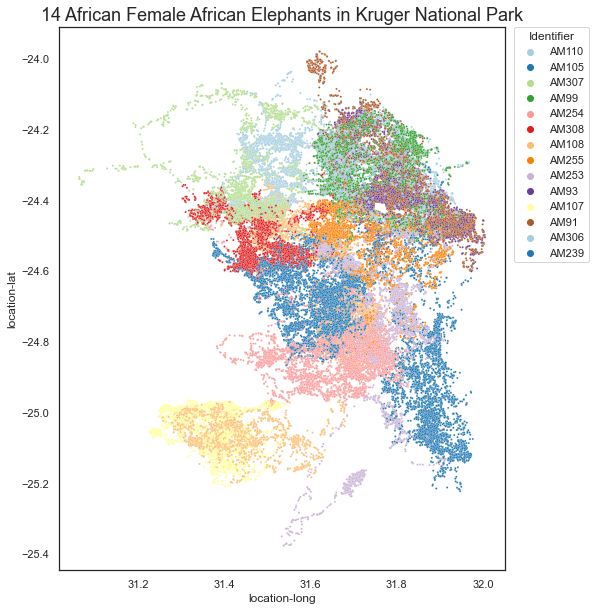

In [17]:
sample = data.sample(n=100000, random_state=42, replace=False)

sns.set(rc={'figure.figsize':(8,10)})
sns.set_style("white")
sns.despine()

sns.scatterplot(data = sample, 
                x="location-long", 
                y="location-lat",
                hue="tag-local-identifier",
                palette="Paired",
                s=4
               )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Identifier")
plt.title("14 African Female African Elephants in Kruger National Park", fontsize=18)
plt.show()

As I would expect, each of the elephants tend to stay within their respective areas (presumably with the rest of their herd), with some overlap with other herds. We can more clearly see where these overlaps happen by calculating the convex hull of each elephant's range. Then, we can find the overlap of each convex hull.

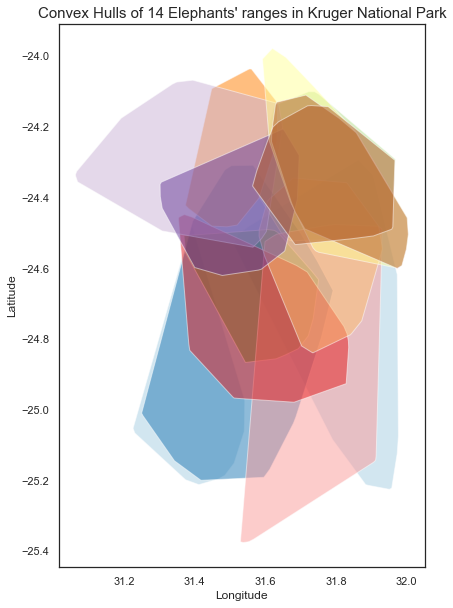

In [23]:
fig, ax = plt.subplots(1,1)


hulls = []
for identifier, group in data.groupby("individual-local-identifier"):
    hull = group.unary_union.convex_hull
    hulls.append([identifier, hull])
hulls_gdf = gpd.GeoDataFrame(hulls, columns=["ID", "geometry"])

hulls_gdf.plot(cmap="Paired", alpha=0.5, ax=ax)

plt.title("Convex Hulls of 14 Elephants' ranges in Kruger National Park", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()
    
    

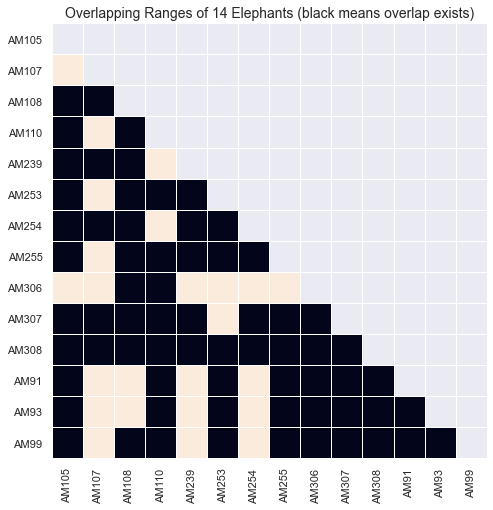

In [24]:
sns.set(rc={'figure.figsize':(10,8)})

# calculate intersections across different elephant ranges
for i, row in hulls_gdf.iterrows():
    intersections = hulls_gdf.geometry.intersects(row.geometry)
    hulls_gdf[row.ID] = intersections
intersections = hulls_gdf.drop(["ID", "geometry"], axis=1)

# plot heatmap
mask = np.triu(np.ones_like(intersections, dtype=bool))
hm = sns.heatmap(1 - intersections, 
            cbar=False, 
            yticklabels=hulls_gdf.ID,
            square=True,
            mask=mask,
            linewidths=.5
           )

plt.title("Overlapping Ranges of 14 Elephants (black means overlap exists)", fontsize=14)
plt.show()

This heatmap reveals a fair amount about how much the various elephant herds overlap with each other. Notably, Elephant `AM107` only overlapped ranges with 5 other elephants. Elephant `AM306` had overlapping areas with 6 of the 13 other elephants. In contrast, elephant `AM308` has overlapping areas with all other elephants. Let's look at these sums in a distributions.

C:\Users\grego\Anaconda3\envs\GIS\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Kurtosis: -0.12014554095195562


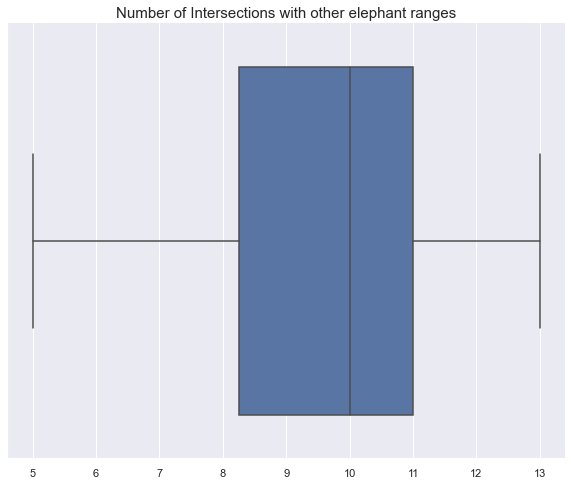

In [25]:
fig, ax = plt.subplots(1,1)


sns.set(rc={'figure.figsize':(12,3)})
sns.set_style("whitegrid")
sns.despine()


# subtract 1 to account for the hull's intersection with itself
sums = intersections.sum() - 1
sns.boxplot(sums, ax=ax)

print("Kurtosis:", kurtosis(sums))
plt.title("Number of Intersections with other elephant ranges", fontsize=15)
plt.show()


According to the boxplot, there are no outliers. It is also fairly normal. (kurtosis = -0.1201)

The last thing I want to examine in regard to the elephant ranges is the area of the overlapping ranges.

In [9]:
def get_intersection_area(row):
    for colname, val in row.iteritems():
        if colname not in ('ID', 'geometry'):
            if val: # intersection
                target_geo = hulls_gdf[hulls_gdf.ID == colname].iloc[0].geometry
                intersection_area = row.geometry.intersection(target_geo).area
                row[colname] = intersection_area
            else:
                row[colname] = 0
    return row

In [10]:
intersections = hulls_gdf.apply(get_intersection_area, axis=1).groupby("ID").sum().sum()
print("Area of range intersections")
print(intersections)

Area of range intersections
AM105    0.940195
AM107    0.291867
AM108    1.041014
AM110    0.589026
AM239    0.436841
AM253    0.806612
AM254    0.659759
AM255    0.605978
AM306    0.232308
AM307    0.422272
AM308    0.458176
AM91     0.576988
AM93     0.516843
AM99     0.563805
dtype: float64


Let's look at the distribution.

Kurtosis: -0.28046187468038664


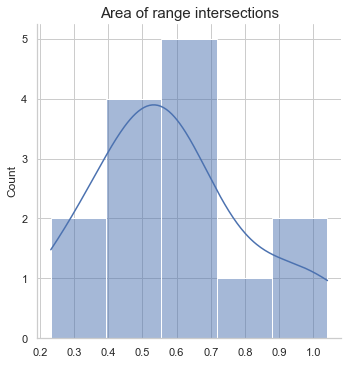

In [11]:
intersections_flattened = np.array(intersections).flatten()

# remove no intersection (0)
intersections_flattened = intersections_flattened[intersections_flattened > 0]
print("Kurtosis:", kurtosis(intersections_flattened))
sns.displot(intersections_flattened, kde=True)

plt.title("Area of range intersections", fontsize=15)
plt.show()

This distribution is also fairly normal (kurtosis = -0.2805). All elephants seems to, in general, share the same amount of overlapping range with other elephants.

## Temperature and Time

Next, I want to look into the temperautre and time columns. First, Let's plot Elephant AM105's points over time with color representing temperature

In [30]:
# credit: 
# https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
# https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import date2num, num2date
import datetime

def map_and_temp(identifier):
    
    # subset data
    subset = data[data["tag-local-identifier"] == identifier]
    
    
    # create figure and axes
    fig, axs = plt.subplots(2,1, figsize=(12,12), gridspec_kw={'height_ratios': [2, 1]})
    
    
    # axis 1
    print("plotting axis 1")
    axs[0].set_title(f"Elephant {identifier} Movement", fontsize=15)
    colormap = plt.cm.get_cmap('hot').reversed()

    vmin = subset["external-temperature"].min()
    vmax = subset["external-temperature"].max()

    subset.plot(column='external-temperature', ax=axs[0], cmap=colormap, vmin=vmin, vmax=vmax, markersize=5)

    # add colorbar
    cbar_fig = axs[0].get_figure()
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = cbar_fig.colorbar(sm, cax=cax)
    cbar.set_label('Temperature (C)', rotation=270, labelpad=20)
    
    
    # axis 2
    print("plotting axis 2")
    # regression line
    subset.loc[:, "timestamp"] = date2num(subset.timestamp)
    sns.scatterplot(
        data=subset, 
        x="timestamp", 
        y="external-temperature", 
        alpha=0.09,
        palette=colormap,
        legend=False,
        hue="external-temperature",
        ax=axs[1], 
    )
    sns.regplot(
        data=subset, 
        x="timestamp", 
        y="external-temperature", 
        ax=axs[1], 
        order=3,
        scatter_kws={'alpha':0},
        line_kws={'color': 'black'}
     )
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Temp (C)")
    axs[1].set_title("Temperature Over Time")
    
    # reset x ticks to dt
    xticks = axs[1].get_xticks()
    xticks_dates = [num2date(x).strftime('%Y-%m-%d') for x in xticks]
    axs[1].set_xticklabels(xticks_dates)
    
    

    plt.subplots_adjust(hspace=0.2)
    plt.show()

plotting axis 1
plotting axis 2


C:\Users\grego\Anaconda3\envs\GIS\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-30-16dd22b74734>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(xticks_dates)


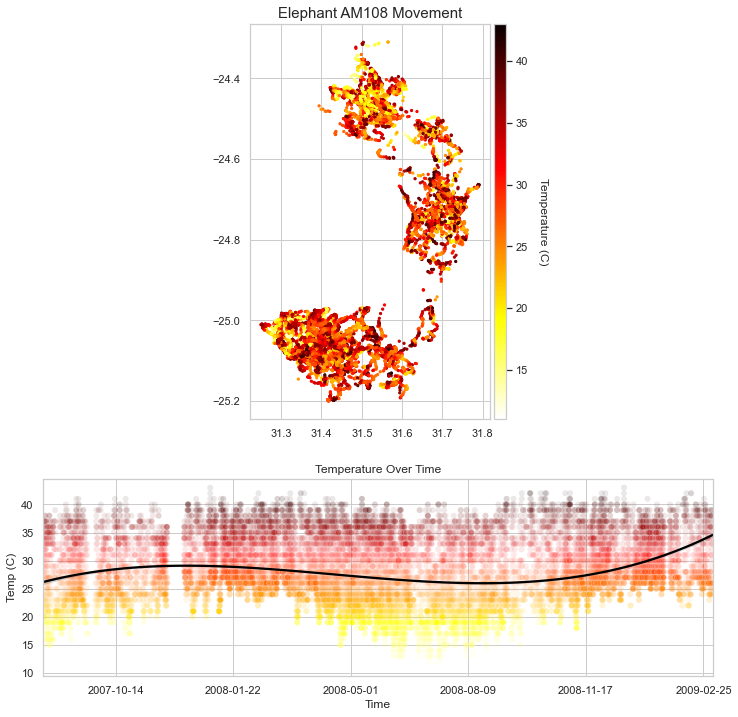

In [31]:
map_and_temp("AM108")

In [363]:
def get_station_temps(elephant_data):

    lat = elephant_data["location-lat"].median()
    long = elephant_data["location-long"].median()
    start = elephant_data.timestamp.min().to_pydatetime()
    end = elephant_data.timestamp.max().to_pydatetime()
        
    # Get nearby weather stations
    stations = Stations()
    stations_query = stations.nearby(nearby_lat, nearby_long)
    stations = stations_query.fetch(10)

    # Filter to stations within the timeframe
    stations = stations[stations["hourly_start"].notnull()]
    possible_stations = stations[(stations["hourly_start"] <= start) & (stations["hourly_end"] >= end)]


    # iterate over possible stations and query stations
    stations_data = []
    num_stations = 0
    for _, station in possible_stations.iterrows():
        wmo = station.wmo
        query = Hourly(wmo, start, end, model=False) # build query
        station_data = query.fetch() # the actual API call
        if station_data.shape[0] > 0:
            num_stations += 1
            station_data["wmo"] = wmo
            stations_data.append(station_data)
    print(f"Getting data from {num_stations} stations")

    stations_df = pd.concat(stations_data)
    stations_df.wmo = stations_df.wmo.astype(int)

    # drop null values
    stations_df = stations_df[stations_df.temp.notna()]
    
    wmo_heat = stations_df[["wmo", "temp"]]
    heat_joined = pd.merge(left=AM105, right=elephant_data, left_on="timestamp", right_index=True).reset_index(drop=True)
    heat_joined.rename(columns={"temp": "stationTemp"}, inplace=True)
    
    return heat_joined